In [1]:
!git clone https://github.com/SushaSureshh/BERT-Research.git

Cloning into 'BERT-Research'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


  # My research Diary - Document classification using the 20news group dataset

This research diary is to shows how to fine-tune BERT for document classification tasks usin the 20news group dataset. The trained model will be then used to generate word embeddings that we can later use to search for "semantically similar" news in the dataset.

*** Hypothesis: To fine tune a BERT model to do classification of 20 news group data with atlease 90% accuracy and use the trained model to find the embedding of the documents in the dataset to eventually use to find most similar documents or clustering***

Let's start

# Using Colab GPU for BERT training
Let's use free GPUs available on collab. The torch uses the GPU, so I specified GPU as the device.

In [ ]:
import tensorflow as tf

# Let's get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# To prevent OOM error to empty the unused memory, let's empy the cache
torch.cuda.empty_cache()

# If there's a GPU available, then
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not, then
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


*Yaay*, I got a Tesla T4. Now let's get the 20news group dataset.

# Data Set

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It has the following categories:

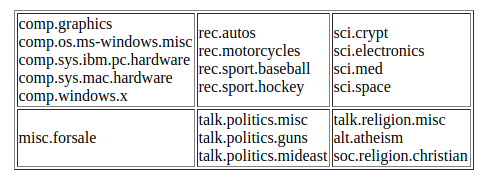

This data can be accessed through multiple dataseources like : https://huggingface.co/datasets/newsgroup, http://qwone.com/~jason/20Newsgroups/#:~:text=The%2020%20Newsgroups%20data%20set%20is%20a%20collection%20of%20approximately,evenly%20across%2020%20different%20newsgroups or from https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html. I chose Scikit Learn for my convenience. The data is divided to both training and test data and the statistics of the data size is 11314 tarining data and 7532 test data. The labels in this classification task is the target which is the category to which the news belong( such as alt.atheism ). I am considering only few categories from all 20 categories because of limited resources.

In [ ]:
!pip install scikit-learn 

from sklearn.datasets import fetch_20newsgroups

In [ ]:
# categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med', 'sci.electronics', 'sci.space', 'talk.politics.guns', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware']
# categories = ['alt.atheism', 'soc.religion.christian']

# news_train = fetch_20newsgroups(subset='train', categories = categories, shuffle=True)
# news_test = fetch_20newsgroups(subset='test', categories = categories, shuffle=True)

news_train = fetch_20newsgroups(subset='train', shuffle=True)
news_test = fetch_20newsgroups(subset='test', shuffle=True)
print('Shape of the tarining data:', news_train.filenames.shape)

print('Shape of the tarining target:',news_train.target.shape)
print('Shape of the test data:', news_test.filenames.shape)
print('Shape of the test target:',news_test.target.shape)
print(news_train.keys())
# print(news_train['target_names'])

Shape of the tarining data: (11314,)
Shape of the tarining target: (11314,)
Shape of the test data: (7532,)
Shape of the test target: (7532,)
dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [ ]:
labels = news_train['target_names']
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Awesome Hugging face library
Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT.

In [ ]:
!pip install transformers 

     |████████████████████████████████| 778kB 5.1MB/s 
     |████████████████████████████████| 3.0MB 24.5MB/s 
     |████████████████████████████████| 1.1MB 57.0MB/s 
     |████████████████████████████████| 890kB 20.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=88cd3d23a5aedd8b352785b17a5dd5a89469b59d3931e18419f186e6b6c412ef
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Input Formatting and tokenization
Befor we feed our data to BERT, we need to tokenize the text. Tokens must be then mapped to their respective indices in the tokenizer vocabulary. I am using the uncased bert-base-uncased tokenizer. Let's download the tokeinizer using the following code.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ',news_train['data'][10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(news_train['data'][10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(news_train['data'][10])))

 Original:  From: irwin@cmptrc.lonestar.org (Irwin Arnstein)
Subject: Re: Recommendation on Duc
Summary: What's it worth?
Distribution: usa
Expires: Sat, 1 May 1993 05:00:00 GMT
Organization: CompuTrac Inc., Richardson TX
Keywords: Ducati, GTS, How much? 
Lines: 13

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)
-------------------------------------------------------

In [ ]:
token = tokenizer.tokenize(news_train['data'][1006]) 
print(len(token))

1575


There are more than 512 tokens ( that is 1063 tokens in this example ). BERT has a maximum input length of 512 tokens. Let's analyse the 512 and the remaining tokens for multiple news to understand the data better. 
Analysis : There are lot of important sentences/words after the 512 tokens.

In [ ]:
#print out the list of tokens
import textwrap
wrapper =textwrap.TextWrapper(width=80)
print('******** First 512 tokens:********')
print(wrapper.fill(str(' '.join(token[0:512]))))
print('')

print('******** Remaining {:,} tokens:********\n'.format(len(token) - 512))
print(wrapper.fill(str(' '.join(token[512:]))))

******** First 512 tokens:********
from : rich . bella ##cera @ ama ##il . am ##dah ##l . com subject : part 1 and
part 2 ( re : homosexuality ) lines : 114 return - path : < ama ##il . am ##dah
##l . com ! rich . bella ##cera @ ju ##ts . cc ##c . am ##dah ##l . com > tony -
i read your post , it was nothing new , i had seen much the same in other
typical " christian " anti - gay sentimental literature . gay people are and
will con - tin ##ue to be persecuted as long as such propaganda pet ##pet ##uate
##s . you may be unaware of all the stat ##istic ##a " findings " concerning
african - americans that have been published and used by various groups to re -
enforce their own bias against african - americans . we usually think of the k
##kk in these instances , but there are many other groups . of course , the vast
majority of the public sc ##off at such findings and documents today , but that
was not always the case . fortunately african - americans had " whites " who
supported their ' 

After reading through multiple posts and research papers, there were numerous findings as jolted below:

Pre-train the model from scratch

1.   Pre-train the model from scratch
2.   Summarise the text ( some how within 512 token limit)
3.   Truncate the token by dropping some of the tokens from head (beginning of the text), tail (end of the text), middle of the text
4. Chunking the tokens: would be to divide the text into 512-token chunks and 
generate embeddings for these chunks separately and then combine the embeddings for the different chunks before performing the final classification. This is computationally expensive and cause error accumulation
The best strategy according to the research paper published recently that investigated this problem and experimented with a few approaches is to simply truncate the document. Let's first tokenize all the data in the training set and look at some statistics.

Tokenize All News

The tokenizer.encode function combines multiple steps:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.


In order to explore the distribution of news lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every news that's longer than 512 tokens. We'll just have to ignore those.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# To record the length of the sequence
lengths = []

# For every sentence...
for doc in news_train['data']:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        doc,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 512,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # Record truncated length
    lengths.append(len(encoded_sent))

# Print sentence 0, now as a list of IDs.
print('Original: ', news_train['data'][0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (964 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1229 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Original:  From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





Token IDs: [101, 2013, 1024, 3393, 2099, 2595, 3367, 1030, 11333, 2213, 1012, 8529, 2094, 1012, 3968, 2226, 1006, 2073, 1005, 1055, 2026, 2518, 1007, 3395, 1024, 2054, 2482, 2003, 2023, 999, 1029, 1050, 3372, 2361, 1011, 14739, 1011, 3677, 1024, 10958, 2278, 2509, 10

Awesome. I see the 101 in beginning and 102 in the end.

In [ ]:
import numpy as np
print(len(input_ids), len(input_ids[0]), len(input_ids[1]))
print('Min length: {:,} tokens'.format(min(lengths)))
print('Max length: {:,} tokens'.format(max(lengths)))
print('Med length: {:,} tokens'.format(np.median(lengths)))

11314 201 216
Min length: 34 tokens
Max length: 52,947 tokens
Med length: 339.0 tokens


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, '# of news')

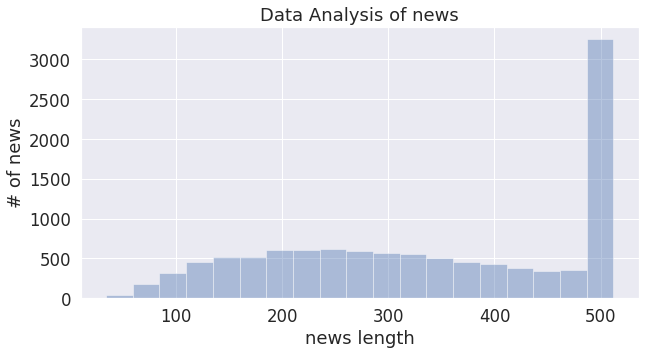

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# Increase the plot size and the plot size

sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (10,5)

#Truntacate any news greater than 100 words length
lengths = [min(l,512) for l in lengths]
# Plot the distribution of the news data lengths
sns.distplot(lengths, kde=False, rug=False)

plt.title('Data Analysis of news')
plt.xlabel('news length')
plt.ylabel('# of news')

In [ ]:
# Count the number of sentences that had to be truncated to 512 tokens
num_truncated = lengths.count(512)
# print(num_padded)

# Compare this to the total number of training sentences
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens'.format(num_truncated,num_sentences, prcnt)) 

2,991 of 11,314 sentences (26.4%) in the training set are longer than 512 tokens


In general 26.3% of the document has more that 512 tokens. I guess for now truncating the documents will be the best strategy. Let us truncate the documents with tokens greater than 512 and pad the documents with tokens less than 512 tokens and then add the attention mask to avoid adding attention to the padded tokens.

In [ ]:
# Pad and truncate the news

from keras.preprocessing.sequence import pad_sequences

#set the required sequence length to either 128 or 512

MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values.. ' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad the input tokens with value 0

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0,truncating="post", padding="post")
print('\nDone')


Padding/truncating all sentences to 512 values.. 

Padding token: "[PAD]", ID: 0

Done


In [ ]:
# Generate the attention masks
attention_masks = []

# For each sentences..
for doc in input_ids:
  attn_mask = [int(token_id > 0) for token_id in doc]

  attention_masks.append(attn_mask)

print('\nDone')


Done


Next step in processing the input to the model is to split the tarining data to train and validation set, so we can test our training efficiency on the validation set. Then I converted the documents and the labels into pytorch  tensors rather than the n-dimensional numpy arrays. We’ll also create an iterator for our dataset using the torch DataLoader class. This helps us save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 and 32, but I was running into OOM errors, to avoid  this I tried to reduce the batch size to 8.

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, news_train.target, random_state=2018, test_size=0.1)


train_masks, validation_masks, _, _ = train_test_split(attention_masks, news_train.target,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all the input labels into torch tensors, required datatype for the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Batch size (how many documets to be trained at a time) chosen 8 to avoid running into OOM
# I tried 16, 32 as well
batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Now that we have our input properly formatted ( that hopefully BERT likes), let us do the document classification by finetuning the BERT model using BERT for sequence classification. I am using bert-base-uncased which is a 12-layer BERT model with lower cased vocabulary.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 20, # The number of expected labels.   
    output_attentions = False, # If the model returns attentions weights.
    output_hidden_states = False, # If the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library 
# with weight decal regularization
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5 as seen in the litrature, choosing
                             # 2e-5
                  eps = 1e-8 # default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (As seen in the literature 4)
epochs = 4

# Total number of training steps is number of batches * epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# Create a schedule with a learning rate that decreases linearly from the initial
# lr set in the optimizer to 0, after a warmup period during 
# which it increases linearly from 0 to the initial lr set in the optimizer.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np


def total_accuracy(preds, labels):
    '''
    Function to calculate the total accuracy of our predictions
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Let's get a human-readable printout of the current memory allocator statistics.
# This was an attempt to solve the runtime error casued due to CUDA OOM
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  428831 KB |  428831 KB |  428831 KB |       0 B  |\n|       from large pool |  428288 KB |  428288 KB |  428288 KB |       0 B  |\n|       from small pool |     543 KB |     543 KB |     543 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  428831 KB |  428831 KB |  428831 KB |       0 B  |\n|       from large pool |  428288 KB |  428288 KB |

Here is what I am doing in the training step:


1.   Unpack our data inputs and labels and load the data to GPU for acceleration
2.   Clear out the gradients calculated in the previous pass to avoid gradient accumulation
3. Forward pass of the model by passing the data to the model followed by the backward pass
4. Update parameters and take a step using the computed gradient.
5. Update the learning rate and track the accuracy and loss for monitoring the learning process

Her is what I am doing in the validation step:

1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Forward pass
4. Compute loss on our validation data and track variables for monitoring progress

In [ ]:
import random

# Set the seed value 42.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# An important parameter is loss, Store the average loss after each epoch for analysis.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ****************************************
    #               Training
    # ****************************************
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # To measure the training time for each epoch .
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches, as seen in literature.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Let's look at Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and load this data to the GPU. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provide the labels

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 as seen in litrature.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # *****************************************
    #               Validation
    # *****************************************
    # After the completion of each training epoch, measure the performance on
    # the validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
             outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to the CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = total_accuracy(logits, label_ids)
        
        # Let's ccalculate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,273.    Elapsed: 0:00:33.
  Batch    80  of  1,273.    Elapsed: 0:01:06.
  Batch   120  of  1,273.    Elapsed: 0:01:38.
  Batch   160  of  1,273.    Elapsed: 0:02:11.
  Batch   200  of  1,273.    Elapsed: 0:02:44.
  Batch   240  of  1,273.    Elapsed: 0:03:16.
  Batch   280  of  1,273.    Elapsed: 0:03:49.
  Batch   320  of  1,273.    Elapsed: 0:04:21.
  Batch   360  of  1,273.    Elapsed: 0:04:54.
  Batch   400  of  1,273.    Elapsed: 0:05:27.
  Batch   440  of  1,273.    Elapsed: 0:05:59.
  Batch   480  of  1,273.    Elapsed: 0:06:32.
  Batch   520  of  1,273.    Elapsed: 0:07:05.
  Batch   560  of  1,273.    Elapsed: 0:07:37.
  Batch   600  of  1,273.    Elapsed: 0:08:10.
  Batch   640  of  1,273.    Elapsed: 0:08:42.
  Batch   680  of  1,273.    Elapsed: 0:09:15.
  Batch   720  of  1,273.    Elapsed: 0:09:48.
  Batch   760  of  1,273.    Elapsed: 0:10:20.
  Batch   800  of  1,273.    Elapsed: 0:10:53.
  Batch   840  of

So the validation accuracy is 94% which is great !! When looking at trainig loss across all batches, the error is gradually reducing and we can see that the model is learning the embeddings for classification tasks.

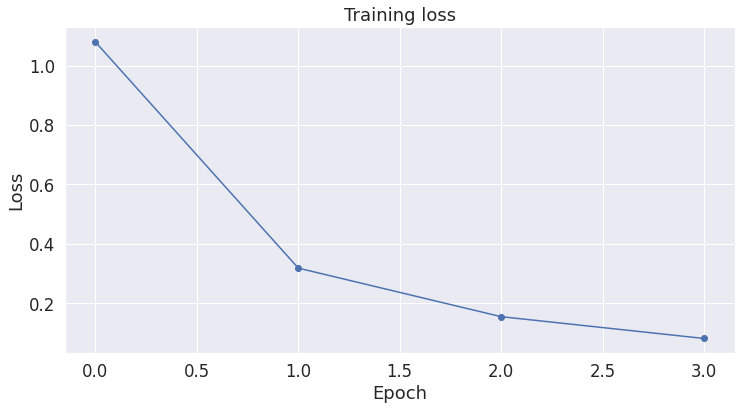

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

Looks good !!

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in news_test['data']:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(news_test.target)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1291 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1597 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Progress update every 100 batches.
  if step % 100 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
        
  # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(prediction_dataloader), elapsed))


    # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
  with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 7,532 test sentences...
    DONE.


In [ ]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
predictions[0:10]

array([[-5.6111521e-01, -6.9739503e-01, -6.2216628e-01,  5.3945172e-01,
         5.5032115e+00, -1.1160156e+00,  8.5209513e-01,  5.8975763e+00,
        -1.0133539e+00, -8.4795678e-01, -1.0138857e+00, -1.2930306e+00,
         5.3207867e-02, -1.1342731e+00,  1.5873216e-01, -6.7437857e-01,
        -6.5530604e-01, -6.1556798e-01, -1.0918976e+00, -4.3525609e-01],
       [ 3.5044625e-02,  3.7304041e+00,  7.7311434e-02, -8.9400989e-01,
        -5.0621545e-01,  7.5381584e+00, -1.9123118e+00, -9.5190579e-01,
        -1.3027573e+00, -1.6553711e+00, -1.9728692e+00, -3.1598365e-01,
        -8.3111674e-01,  3.9626446e-01,  2.1695337e-01, -3.0959508e-01,
        -7.7949840e-01, -4.5218725e-02, -2.6432700e+00,  1.8134740e-01],
       [ 8.4890337e+00,  2.1882690e-01, -8.3865929e-01, -7.1321052e-01,
        -8.3301413e-01,  1.7977406e-01, -1.3876334e+00, -3.6437905e-01,
        -5.8188355e-01, -1.5496377e+00, -9.1622972e-01, -2.3891582e-01,
        -5.6539512e-01, -6.9175220e-01, -8.3231241e-01,  5.696

In [ ]:
accuracy_test = total_accuracy(predictions, true_labels)
print("The test accuracy is:" , accuracy_test)

The test accuracy is: 0.8615241635687733


The accuracy on test set is also great!!

In [ ]:
# Let's save the model

import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 428052K
-rw-r--r-- 1 root root      2K Aug 28 17:43 config.json
-rw-r--r-- 1 root root 427807K Aug 28 17:43 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 28 17:43 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug 28 17:43 tokenizer_config.json
-rw-r--r-- 1 root root    227K Aug 28 17:43 vocab.txt


# Vectorize the news document
## To create these embeddings, we'll simply run the news documents through the model the same way we did for training, but we'll take the embedding corresponding to the [CLS] token from the final BERT Transformer layer. Before we can use our fine-tuned model for extracting embeddings, we first need to reload the model from disk with the output_hidden_states flag set to True.

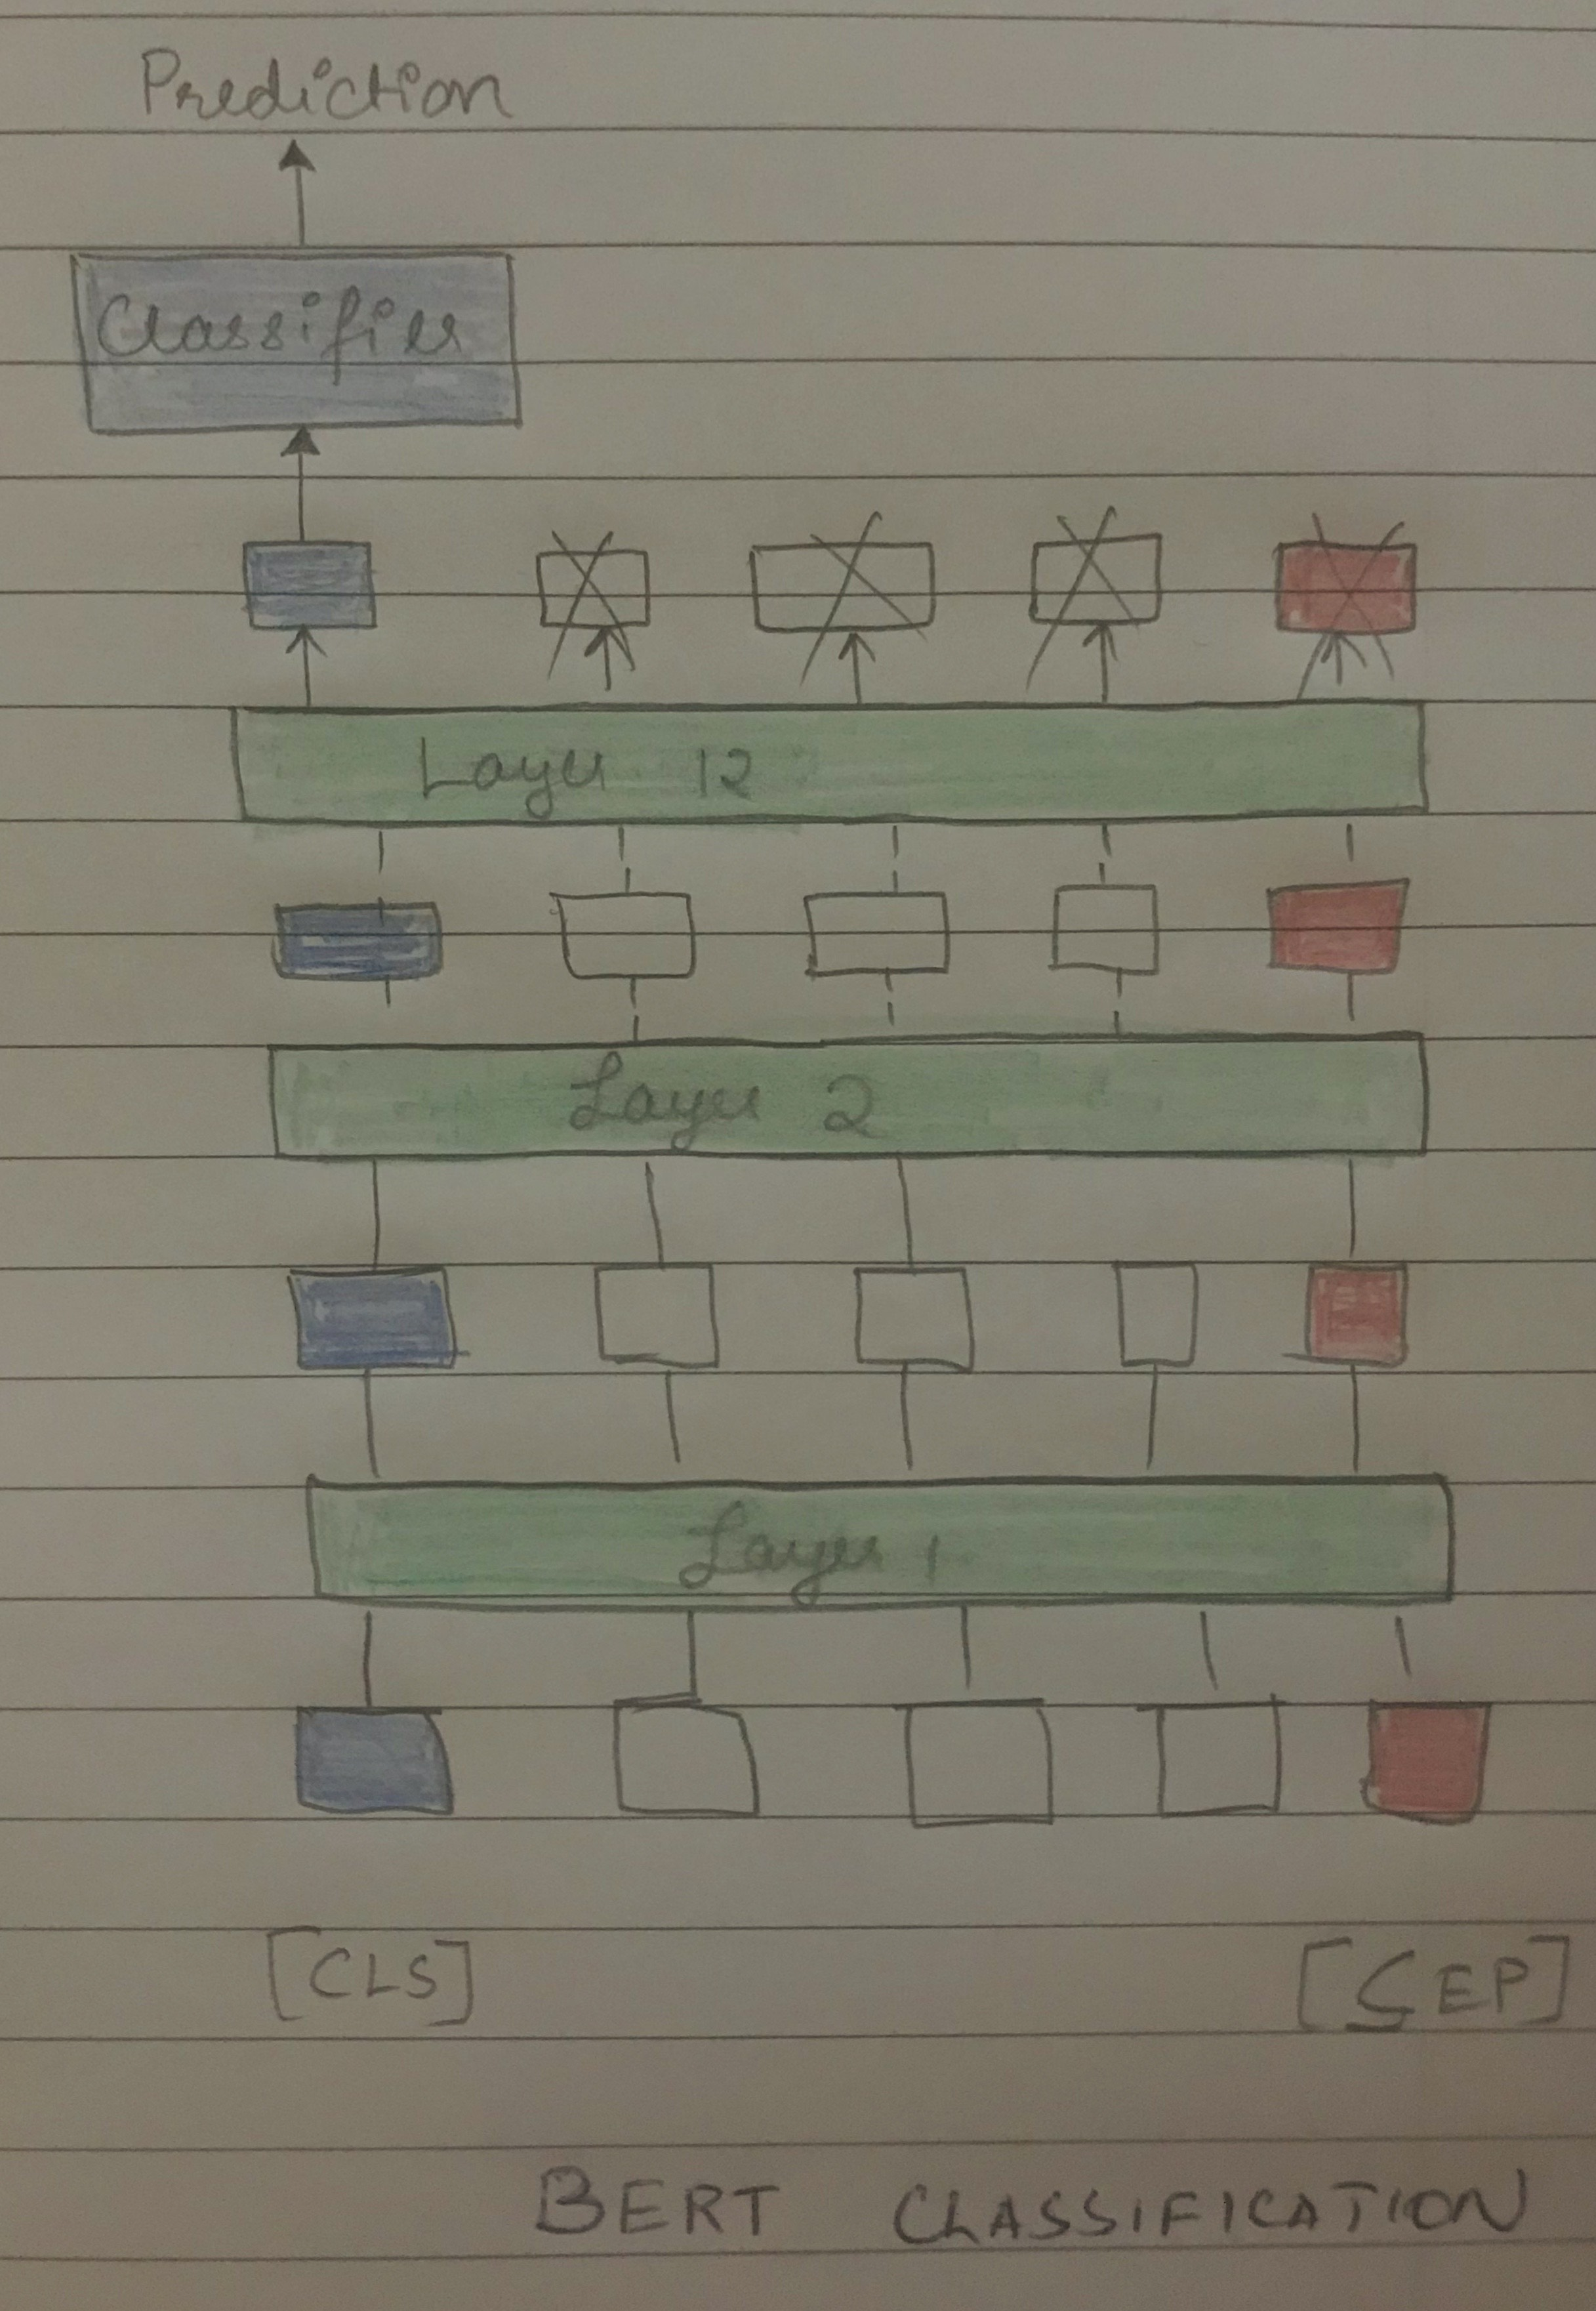

In [ ]:
model.output_hidden_states = True

Now we can load our model's weights, this time enabling the `output_hidden_states` flag. 

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
) 

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# text_to_embedding function

Here we'll define a function which can take an arbitrary piece of text (news in this case) and use our fine-tuned BERT model to compute a feature vector (embedding) for the text.

We'll be using the 768-feature vector corresponding to the special `[CLS]` token, taken from the final layer of the transformer.

I am converting the documents one at time but we can also do it in batch.

In [ ]:
import torch
from keras.preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 512

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result 
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # As I did not pass any labels, the model knows it is a 
        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids, 
                                    token_type_ids = None, 
                                    attention_mask = attn_mask)
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)

Let's vectorize the 100th data from the dataset to 768 dimensions.

In [ ]:
# Get the text from one of the news.
input_text = news_train['data'][100]

# Use `textwrap` to print the sentence nicely.
wrapper = textwrap.TextWrapper(initial_indent="    ", subsequent_indent="    ", 
                               width = 80)

print('Getting embedding for sentence:\n\n', wrapper.fill(input_text))

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print('\nDone. Embedding shape:', str(vec.shape))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Getting embedding for sentence:

     From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen) Subject: ** Software
    forsale (lots) ** Nntp-Posting-Host: magnusug.magnus.acs.ohio-state.edu
    Organization: The Ohio State University     ****   This is a post for my
    friend,  You can either call    ****     ****    him  J.K Lee  (614)791-0748
    or Drop me a mail     **** Distribution: usa Lines: 39  1.  Software
    publishing SuperBase 4 windows v.1.3           --->$80  2.  OCR System
    ReadRight v.3.1 for Windows                  --->$65  3.  OCR System
    ReadRight  v.2.01 for DOS                    --->$65  4.  Unregistered
    Zortech 32 bit C++ Compiler v.3.1          --->$ 250      with Multiscope
    windows Debugger,      WhiteWater Resource Toolkit, Library Source Code  5.
    Glockenspiel/ImageSoft Commonview 2 Windows      Applications Framework for
    Borland C++                 --->$70  6.  Spontaneous Assembly Library With
    Source Code           --->$50  7.  

In [ ]:
print('\nDone. Embeddings of the news document:', vec)


Done. Embeddings of the news document: [-0.8091789  -0.24869196 -0.86175865 -0.6648762   0.35853645 -1.085641
  1.1319207  -0.14635944  0.4958557  -0.40445498 -0.42726594 -1.2385169
 -0.35629305  1.7627288   0.47105595  1.0574013  -0.48715666  0.17589049
 -1.1329666  -0.29504415  0.03574927 -0.4373842  -0.14177404 -0.15087016
  0.6653786  -0.12505427 -0.07990454 -0.980986    1.0177056   1.284826
  0.15416968 -0.1359413  -0.16935225  0.12659091 -0.21829101 -0.44544598
 -0.70896524 -0.9044238  -0.5533784   0.05041875  0.3452284  -0.64703524
  1.4340498  -0.32878318 -1.4237508  -0.4073263  -0.28547236  0.32811305
 -0.7823183   0.4225855  -0.19883786 -0.12145428  1.400569   -0.6415718
  0.0643466   0.69747734 -1.0855917  -0.21278869  0.23135035 -0.24339695
 -0.81750244 -0.26984158  0.90525997  0.4764189   0.41858068  0.70025676
 -0.36645338  0.80850166 -0.49146348  0.49857578  0.5284236  -0.27635166
  0.7025617  -1.0529318  -0.09506002 -1.7815039  -0.08568176  0.7146143
 -0.31196547 -0.43

Voilaaaaaaaaaaaaaaaaaa !!! we have the embeddings of the news documents. We can now use these Embeddings
in documet similarity or the document clustering tasks.

# Appendix

Here I will do the additional points mentioned in the assessment.

I will first vectorize the whole dataset.

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_news = len(news_train['data'])

print('Generating sentence embeddings for all {:,} news...'.format(num_news))

row_num = 0

# For each row of the dataframe...
for doc in news_train['data']:

    # Progress update every 2,000 news documents.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_news - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  News {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_news, elapsed, remaining))

    # Vectorize this news data.
    vec = text_to_embedding(tokenizer, model, news_train['data'])

    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generating sentence embeddings for all 11,314 news...


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

  News   2,000  of   11,314.    Elapsed: 0:10:01. Remaining: 0:46:40


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

  News   4,000  of   11,314.    Elapsed: 0:19:59. Remaining: 0:36:32


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

  News   6,000  of   11,314.    Elapsed: 0:29:56. Remaining: 0:26:31


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

  News   8,000  of   11,314.    Elapsed: 0:39:52. Remaining: 0:16:31


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

  News  10,000  of   11,314.    Elapsed: 0:49:48. Remaining: 0:06:33


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [ ]:
import numpy as np

# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

(11314, 768)

We have a matrix of 11314 document embeddings with 768 dimensions.

In [ ]:
# Let's save the model
import numpy as np
import os

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)

# # Copy the embeddings to a directory in my Google Drive.
# !cp -r ./model_save/embeddings.npy "./drive/My Drive/BERT Document Classification/model_save/"

Saving embeddings to: ./model_save/embeddings.npy


# Semantic Similarity Search

Now that we have our news data all vectorized, we are ready to make them "searchable".

We do this using a technique called "k-Nearest Neighbor Search" or "k-NN". Simply put, we use a distance metric such as Euclidean distance/cosine distance, calculate that distance between our "query" vector and all of the vectors to be searched, then sort the distances to find the closest matches.

I used FAISS for this, I first indexed the documents into the index and later tried to print 5 top similar news documents for news #4

In [ ]:
!pip install faiss

     |████████████████████████████████| 4.7MB 5.2MB/s 


In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 35.5MB 197kB/s 


In [ ]:
import faiss

# =====================================
#            FAISS Setup
# =====================================

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPUs. 
print('Number of available GPUs: %d    Using: %d' % (faiss.get_num_gpus(), n_gpu))

# If using multiple GPUs, enable sharding so that the dataset is divided across 
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()    

gpu_index.add(vecs)

elapsed = time.time() - t0
print('Building index took %.2f seconds' % (elapsed))

Number of available GPUs: 1    Using: 1
Adding dataset to index...
Building index took 0.02 seconds


The indexing was done in 0.01 seconds

In [ ]:
# News number 2 is short and sweet.
print('==== Input news data =====')
print('News #200:')
print(wrapper.fill(news_train['data'][200]))

# Let's find the 5 most similar news,and retrieve the indices and the distances
D, I = gpu_index.search(vecs[2].reshape(1, 768), k=5) 
# D = gpu_index.search(vecs[2].reshape(1, 768), k=5)
print(D)
print(I)
print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the news to produce result.
    result_i = I[0, i]

    # Look up the text for this news.
    text = news_train['data'][result_i]
    print('New #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print(wrapper.fill('"' + text + '"'))
    print('')

==== Input news data =====
News #1:
    Subject: Re: "Proper gun control?" What is proper gun cont From:
    kim39@scws8.harvard.edu (John Kim) Organization: Harvard University Science
    Center Nntp-Posting-Host: scws8.harvard.edu Lines: 17  In article
    <C5JGz5.34J@SSD.intel.com> hays@ssd.intel.com (Kirk Hays) writes: >I'd like
    to point out that I was in error - "Terminator" began posting only  >six
    months before he purchased his first firearm, according to private email
    >from him. >I can't produce an archived posting of his earlier than January
    1992, >and he purchased his first firearm in March 1992. >I guess it only
    seemed like years. >Kirk Hays - NRA Life, seventh generation.  I first read
    and consulted rec.guns in the summer of 1991.  I just purchased my first
    firearm in early March of this year.   NOt for lack of desire for a firearm,
    you understand.  I could  have purchased a rifle or shotgun but didn't want
    one. -Case Kim
[[0.00030518 0.0

We have the results, but the results are not great.

Analysis : In order to accomodate fine tuning BERT on the GPU, I had to cut short the number of categories to 9. Eventhough it gives a good tarining accuracy, the limited number of documents might have not have produced the best document embeddings.